In [1]:
# let's import important libraries
import numpy as np
from matplotlib import pyplot as plt
import math

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout, Flatten
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Model

import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

import seaborn as sns

## Let's train the model for detect anomalies using orientaion x

In [2]:
# truncate the full data to check only orientation x

dataframe = pd.read_csv('../extract-data/ICAB1/02_icab1_reverse_fail_overtaking0_2021-03-26-14-40-28_0/icab1-mavros-imu-data.csv', usecols=[5])
#dataframe = pd.read_csv('../extract-data/ICAB1/02_icab1_reverse_fail_overtaking0_2021-03-26-14-40-28_0/icab1-mavros-imu-data.csv')
#df = dataframe[['Time', 'orientation.x']]

#convert time step to the date and time format
#df['Time'] = pd.to_datetime(df['Time'], unit='s')
#df
dataframe

,orientation.x
0,-0.036490
1,-0.036553
2,-0.036523
3,-0.036695
4,-0.036460
...,...
754,-0.026291
755,-0.026335
756,-0.026449
757,-0.026561


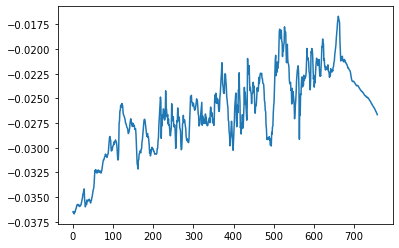

In [3]:
# plot the variation vs time i
plt.plot(dataframe)

#sns.lineplot(x=dataframe['Time'], y=dataframe['orientation.x'])

In [4]:
# print the start and ending dates for collecting datas
#print("Start date is: ", df['Time'].min())
#print("End date is: ", df['Time'].max())

In [5]:
# create the data set to numpy array
dataset_array = dataframe.values
dataset_array = dataset_array.astype('float32') # convert values to float
dataset_array.shape # this is a coloumn matrix
#print(dataset_array)


(759, 1)

#### In LSTM it is widely use tanh and sigmoid as activation functions..........

#### So need to scale our data set between zero and one (since activation functions varies between these two values)

In [6]:
# check the min value of data set and it is appointed as zero.... max value is appointed as one
scale = MinMaxScaler(feature_range=(0, 1)) # define a scaler of range (0,1)
transformed_dataset = scale.fit_transform(dataset_array)
print(transformed_dataset.shape)
print(len(transformed_dataset))
#print(transformed_dataset)

(759, 1)
759


In [7]:
#Divide the whole data set to training & testing sets .. 
train_size = int(len(transformed_dataset) * 0.66) # take 2/3 of whole data for train
test_size = len(transformed_dataset) - train_size
#print("train_size : ", train_size)
#print("test_size : ", test_size)

train, test = transformed_dataset[0:train_size,:], transformed_dataset[train_size:len(transformed_dataset),:]
#print("train : ", train)
#print("test : ", test)
print(train.shape)
print(test.shape)


(500, 1)
(259, 1)


#### Normaly we have to predict next value using previous values.. currently our data is in one column... I choose previous 3 data to predict next 
#### Have to reconstruct the dataset with 3 columns for input data (x)........... dataset with 1 column for output data(y)

In [8]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

seq_size = 3  # Number of time steps to look back 


trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)
# you can see one row consist of consecutive 3 values of data and 5th value is data is take as an output for 1st row
#print("Train X = ", trainX) 
#print(" ")
#print("Train Y = ", trainY)
#print(" ")
print("Shape of training set Input : ", trainX.shape)
print("Shape of training set Output: ", trainY.shape)
print(" ")
print("Shape of testing set Input : ", testX.shape)
print("Shape of testing set Output: ", testY.shape)


Shape of training set Input :  (496, 3)
Shape of training set Output:  (496,)
 
Shape of testing set Input :  (255, 3)
Shape of testing set Output:  (255,)


#### The input to every LSTM layer must be three-dimensional.

#### The three dimensions of this input are:

1. __Samples :__ One sequence is one sample. A batch is comprised of one or more samples.
2. __Time Steps:__ One time step is one point of observation in the sample.
3. __Features:__ One feature is one observation at a time step.

In [9]:
# Reshape input to be [samples, time steps, features]


reshaped_trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
reshaped_testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Single LSTM with hidden Dense...')
model = Sequential()
# number of LSTM cells that used = 64
model.add(LSTM(64, input_shape=(None, seq_size)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()
print('Train...')

Single LSTM with hidden Dense...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 19,521
Trainable params: 19,521
Non-trainable params: 0
_________________________________________________________________
Train...


In [20]:
model.compile(loss='mean_squared_error', optimizer='adam')
#model.compile(optimizer='adam',loss='mean_squared_error',metrics=["accuracy"])
history=model.fit(reshaped_trainX, trainY, validation_data=(reshaped_testX,testY),verbose = 1, epochs=50, batch_size=50,)
#history = model.fit(reshaped_trainX, trainY, validation_data=(reshaped_testX, testY),verbose=2, epochs=100)

Epoch 1/50
10/10 [==============================] - 2s 60ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 2/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 3/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 4/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 5/50
10/10 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 6/50
10/10 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 7/50
10/10 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 8/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 9/50
10/10 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 10/50
10/10 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 11/50
10/10 

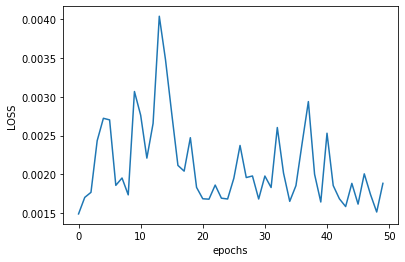

In [22]:
loss_history = (history.history['val_loss'])
fig, axes = plt.subplots()
axes.plot(loss_history)  
axes.set_xlabel("epochs")
axes.set_ylabel("LOSS")
plt.show()
fig.savefig('LOSS.png',transparent=True)

In [24]:
# make predictions

trainPredict = model.predict(reshaped_trainX)
testPredict = model.predict(reshaped_testX)

# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict = scale.inverse_transform(trainPredict)
trainY = scale.inverse_transform([trainY])
testPredict = scale.inverse_transform(testPredict)
testY = scale.inverse_transform([testY])

Train Score: 0.00 RMSE
Test Score: 0.00 RMSE


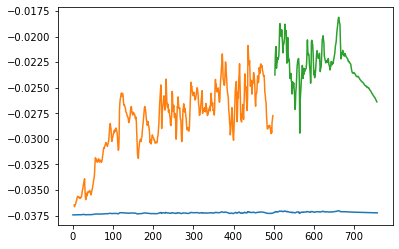

In [27]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset_array)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset_array)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset_array)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scale.inverse_transform(dataset_array))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()